## 1. Librerias

In [6]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pdf2image import convert_from_path

## 2. Crear carpetas para carga de imágenes y resultados

In [2]:
os.makedirs('./data', exist_ok=True)
os.makedirs('./outputs', exist_ok=True)

## 3. Ruta imagen de entrada y configuración para procesamiento

In [59]:
INPUT_PATH = r'./data/plano2.jpg'

In [189]:
CFG = {
    "blur": 3,           # Tamaño del kernel para desenfoque gaussiano
    "canny_low": 50,     # Umbral bajo para Canny
    "canny_high": 150,   # Umbral alto para Canny
    "morph_kernel": 3    # Tamaño del kernel para operaciones morfológicas
}

## 4. Función para cargar el archivo (imagen o PDF)

In [7]:
def load_image(input_path):
    extension = os.path.splitext(input_path)[1].lower()
    if extension == '.pdf':
        pages = convert_from_path(input_path, dpi=600, first_page=1, last_page=1)
        img_pil = pages[0].convert('RGB')
        img_np = np.array(img_pil)
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    else:
        img_pil = Image.open(input_path).convert('RGB')
        img_np = np.array(img_pil)
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    return img_np

### 4.1. Prueba

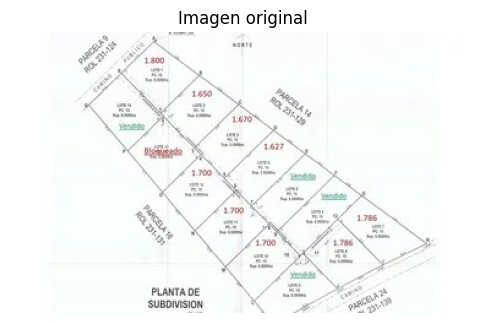

In [191]:
image_bgr = load_image(INPUT_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.title('Imagen original')
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

## 5. Función para procesamiento

In [8]:
def preprocesar_imagen(image_bgr, cfg):
    """
    Preprocesa una imagen BGR aplicando:
    - Escala de grises
    - Desenfoque gaussiano
    - Mejora de contraste (CLAHE)
    - Detección de bordes con Canny
    - Cierre morfológico para limpieza
    - Filtrado de contornos por área mínima

    Parámetros:
        image_bgr: Imagen en formato BGR (como la carga cv2.imread)
        cfg: Diccionario de configuración con claves:
             "blur", "canny_low", "canny_high", "morph_kernel", "min_contour_area"

    Retorna:
        gray, blurred, contrast, edges, edges_morph, filtered_contours
    """

    # Escala de grises
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

    # Desenfoque gaussiano
    blurred = cv2.GaussianBlur(gray, (cfg["blur"], cfg["blur"]), 0)

    # Mejora de contraste (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast = clahe.apply(blurred)

    # Bordes Canny
    edges = cv2.Canny(contrast, cfg["canny_low"], cfg["canny_high"])

    # Cierre morfológico
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (cfg["morph_kernel"], cfg["morph_kernel"]))
    edges_morph = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # Encontrar contornos y filtrar por área
    contours, _ = cv2.findContours(edges_morph, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filtrar contornos por área mínima
    min_area = cfg["min_contour_area"]
    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > min_area]
    
    print(f"Contornos totales encontrados: {len(contours)}")
    print(f"Contornos filtrados (área > {min_area}): {len(filtered_contours)}")

    return gray, blurred, contrast, edges, edges_morph, filtered_contours

## 6. Función para mostrar y guardar resultados

In [9]:
def mostrar_y_guardar_resultados(image_rgb, gray, blurred, contrast, edges, edges_morph, filtered_contours):
    """
    Muestra los resultados intermedios del preprocesamiento y guarda las imágenes finales:
    - Imagen en grises, desenfoque, contraste
    - Bordes detectados y bordes refinados (morfología)
    - Contornos filtrados sobre la imagen original
    También guarda en ./outputs las imágenes de bordes y contornos.

    Parámetros:
        image_rgb: Imagen original en formato RGB
        gray: Imagen en escala de grises
        blurred: Imagen desenfocada
        contrast: Imagen con contraste mejorado
        edges: Bordes detectados con Canny
        edges_morph: Bordes refinados con morfología
        filtered_contours: Lista de contornos filtrados por área
    """

    # --- Mostrar imágenes intermedias ---
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.title('Grises')
    plt.imshow(gray, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Desenfoque')
    plt.imshow(blurred, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Contraste mejorado')
    plt.imshow(contrast, cmap='gray')
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title('Bordes Canny')
    plt.imshow(edges, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Bordes + Morfología')
    plt.imshow(edges_morph, cmap='gray')
    plt.axis('off')
    plt.show()

    # --- Dibujar contornos filtrados sobre la imagen original ---
    contour_img = image_rgb.copy()
    cv2.drawContours(contour_img, filtered_contours, -1, (255, 0, 0), 2)

    plt.figure(figsize=(6, 6))
    plt.title(f'Contornos filtrados sobre imagen original ({len(filtered_contours)} contornos)')
    plt.imshow(contour_img)
    plt.axis('off')
    plt.show()

## Testeo y resultados

In [10]:
CFG = {
    "blur": 3,           # Tamaño del kernel para desenfoque gaussiano
    "canny_low": 50,     # Umbral bajo para Canny
    "canny_high": 150,   # Umbral alto para Canny
    "morph_kernel": 2,    # Tamaño del kernel para operaciones morfológicas
    "min_contour_area": 1000  # Área mínima para filtrar contornos pequeños (texto)
}


Procesando: ./data/plano1.png


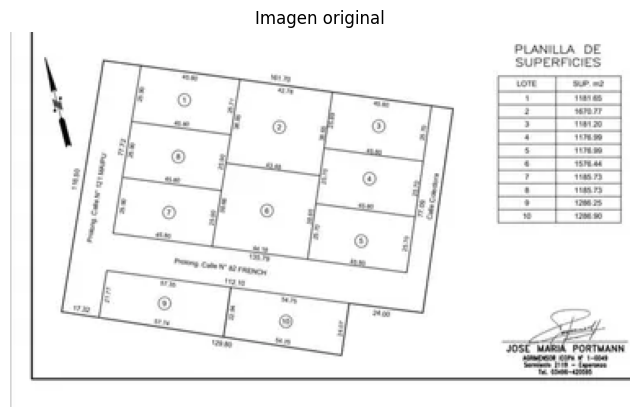

Contornos totales encontrados: 543
Contornos filtrados (área > 1000): 14


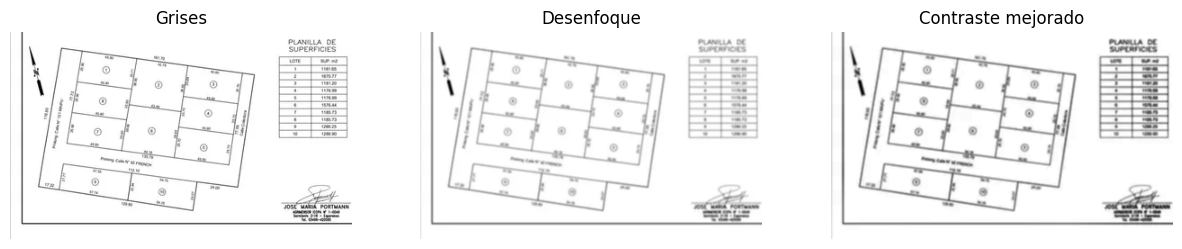

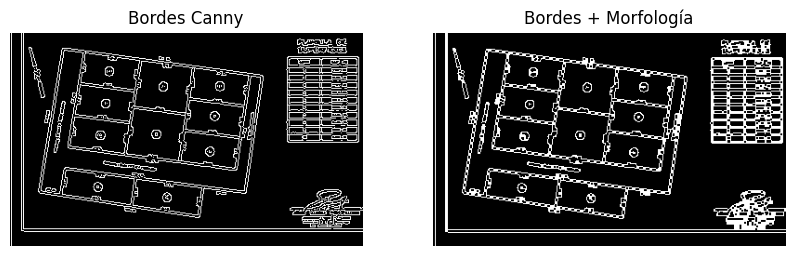

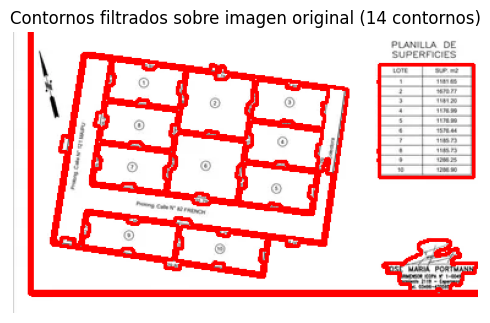


Procesando: ./data/plano2.jpg


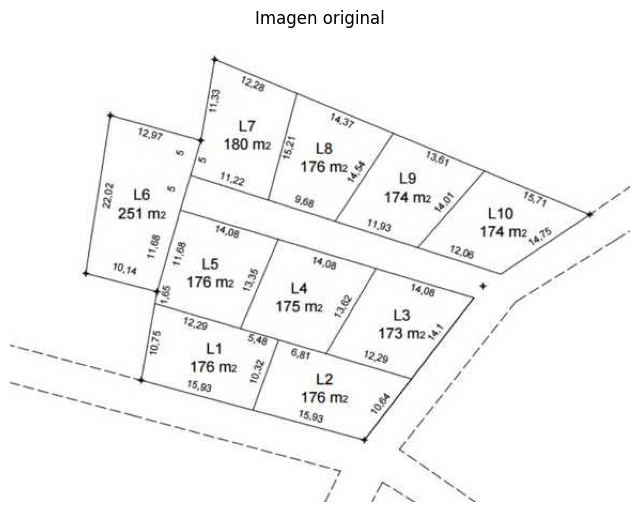

Contornos totales encontrados: 999
Contornos filtrados (área > 1000): 11


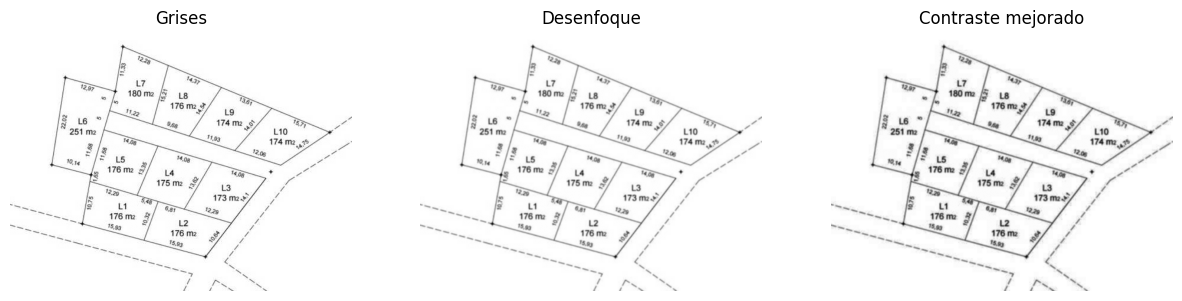

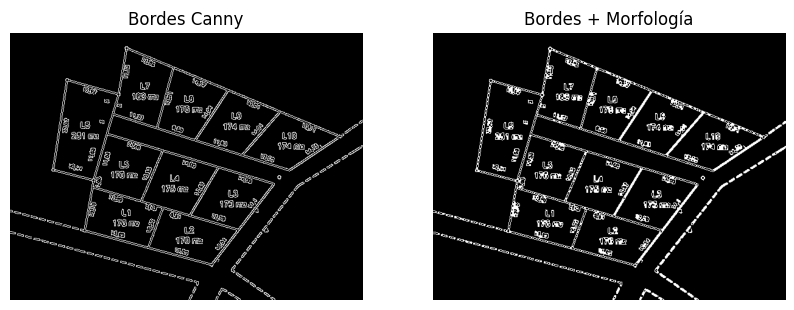

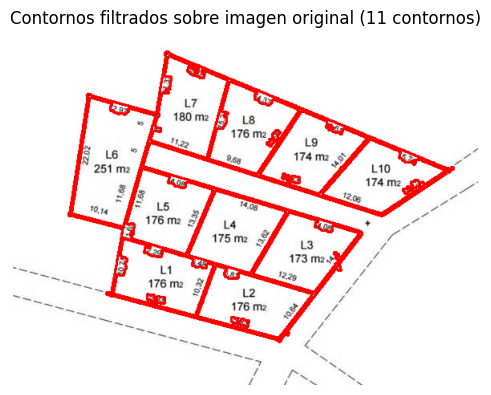


Procesando: ./data/plano3.jpeg


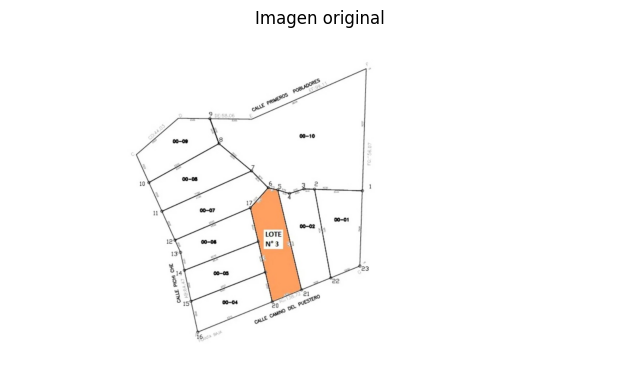

Contornos totales encontrados: 775
Contornos filtrados (área > 1000): 13


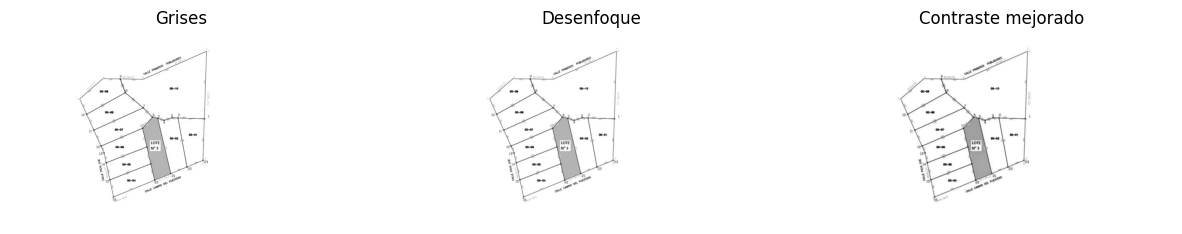

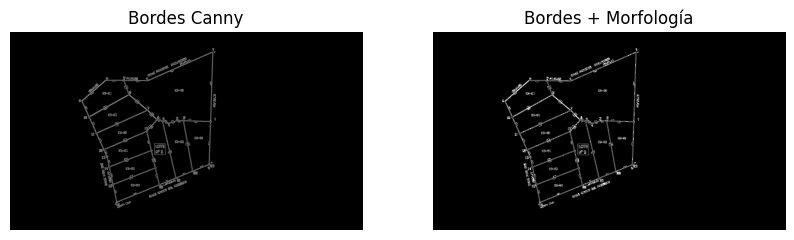

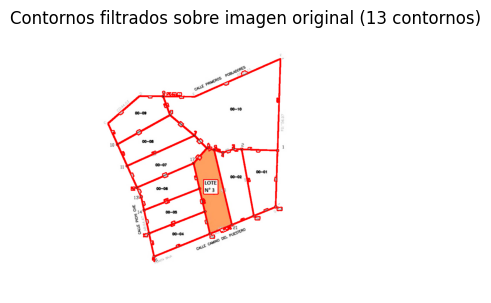


Procesando: ./data/plano4.jpeg


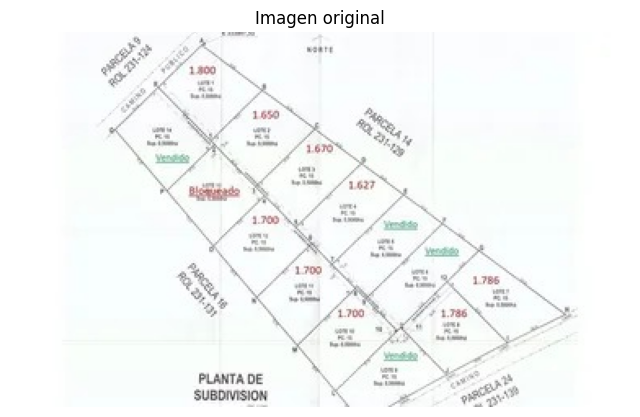

Contornos totales encontrados: 267
Contornos filtrados (área > 1000): 14


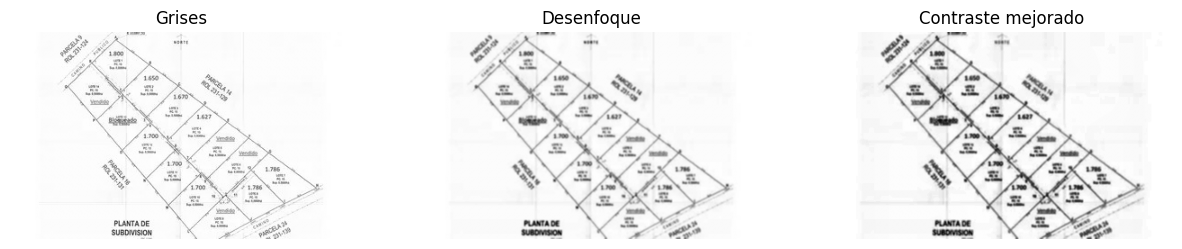

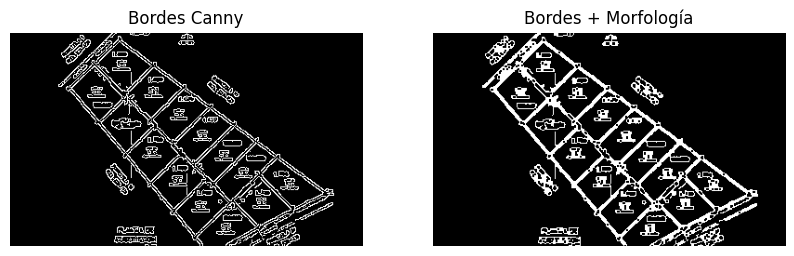

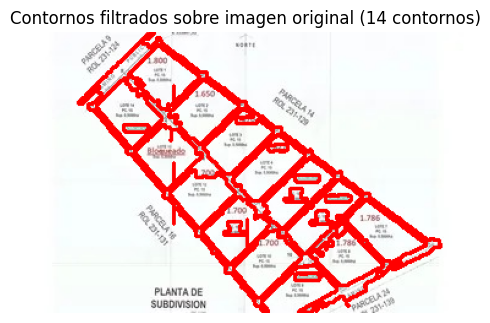


Procesando: ./data/plano5.png


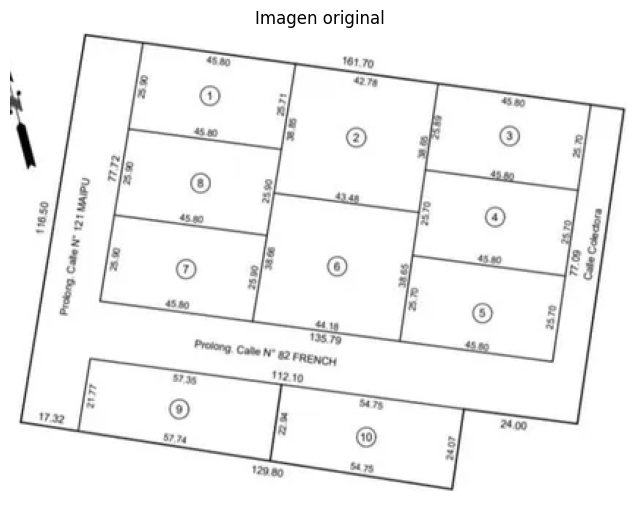

Contornos totales encontrados: 714
Contornos filtrados (área > 1000): 12


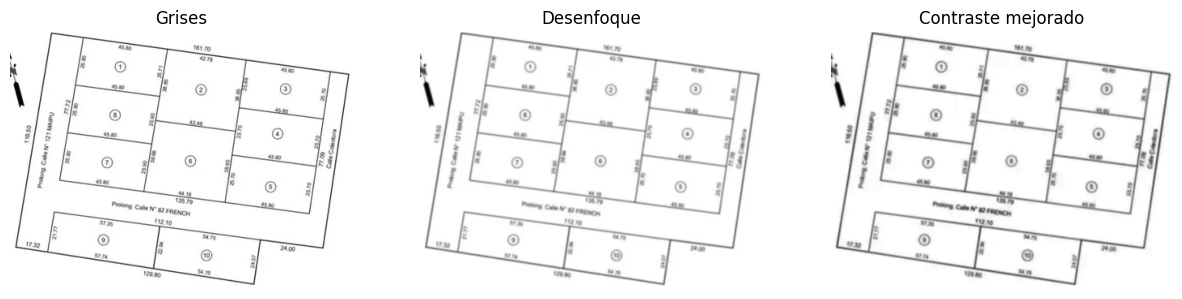

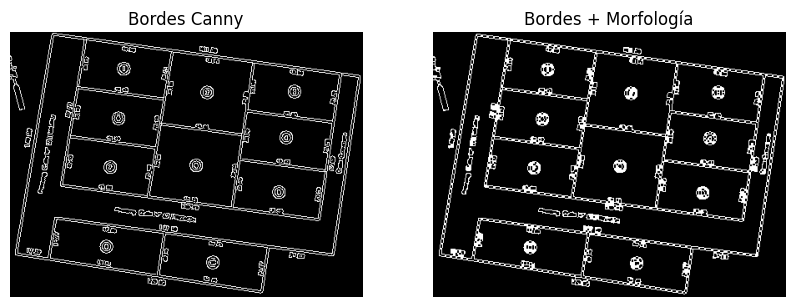

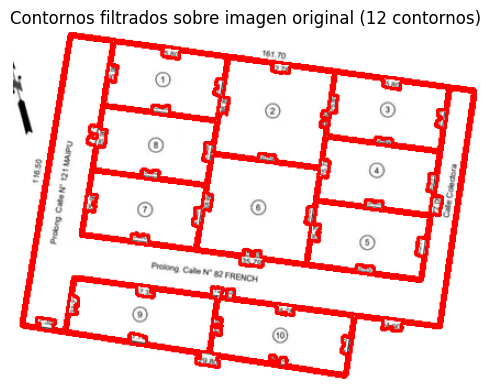


Procesando: ./data/plano6.png


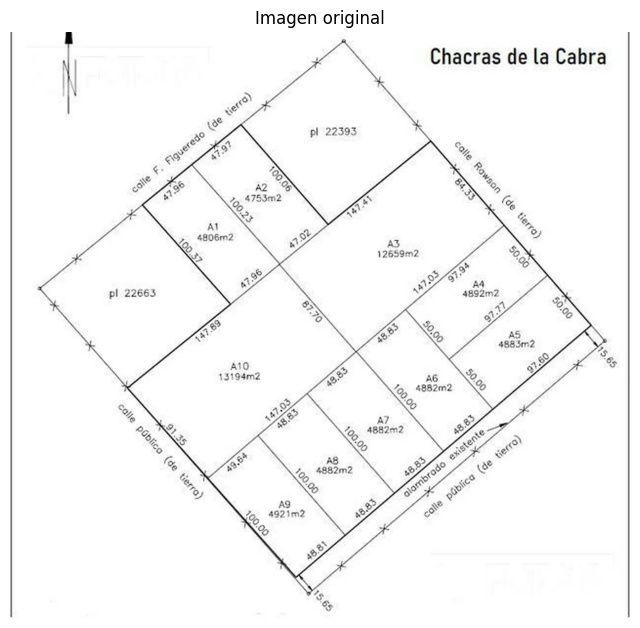

Contornos totales encontrados: 3127
Contornos filtrados (área > 1000): 20


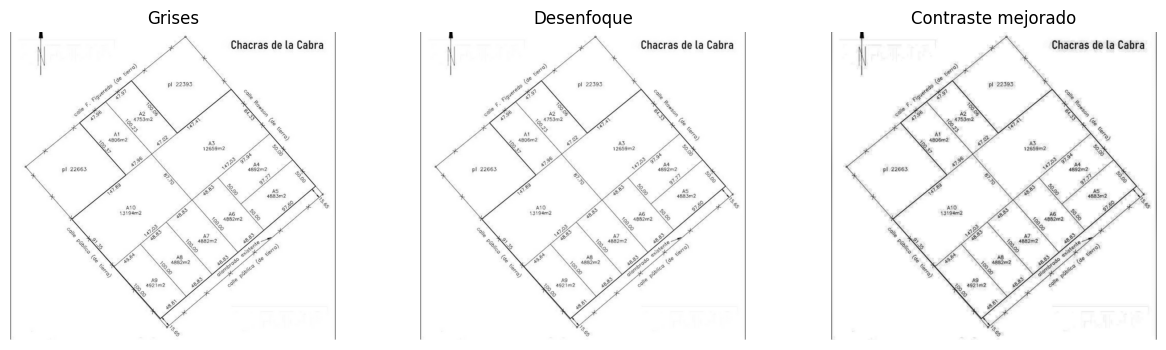

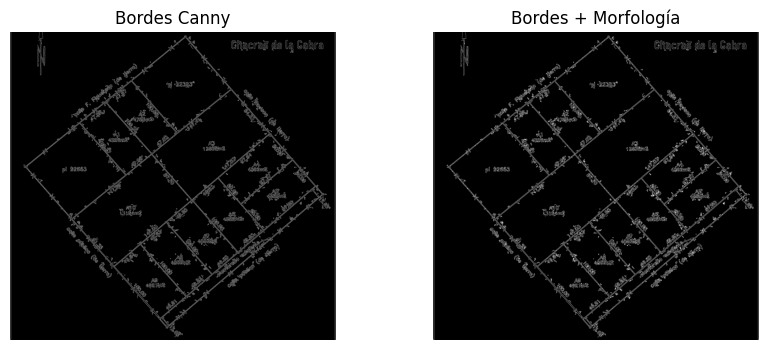

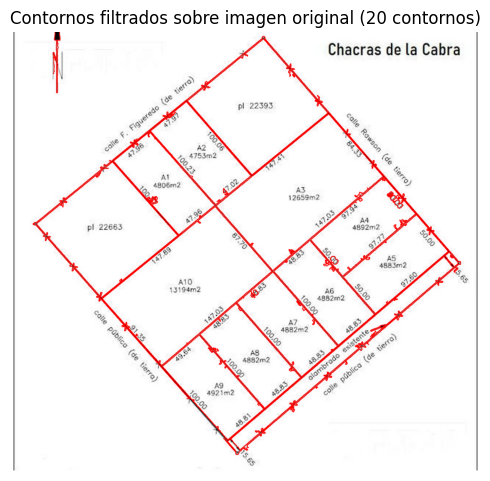


Procesando: ./data/plano7.png


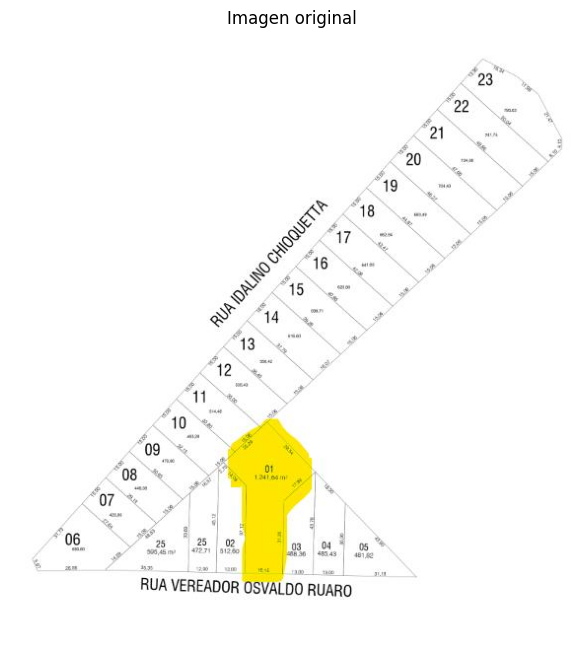

Contornos totales encontrados: 611
Contornos filtrados (área > 1000): 25


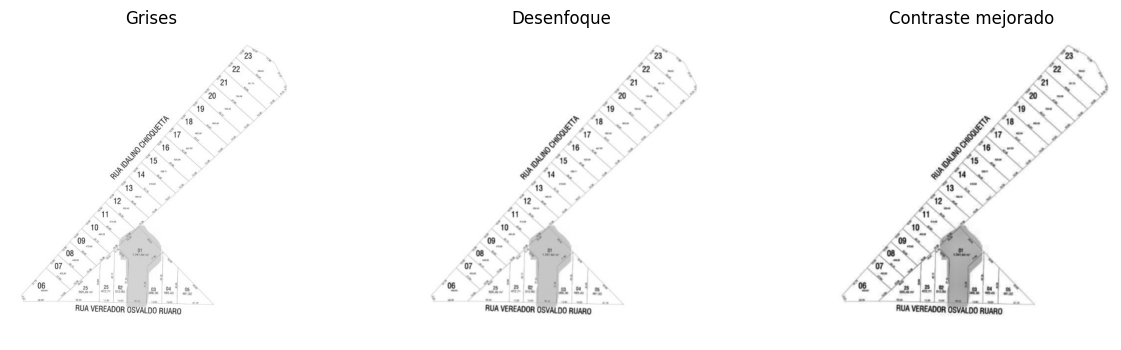

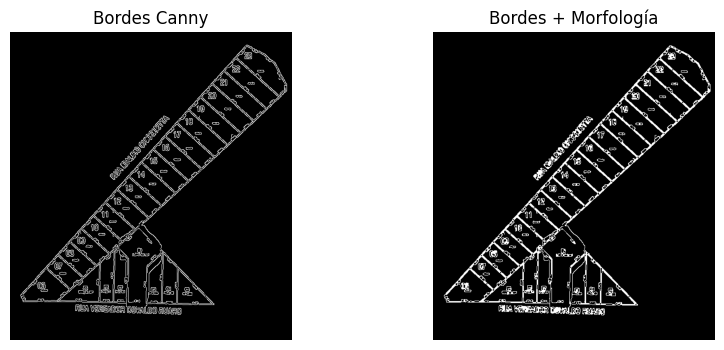

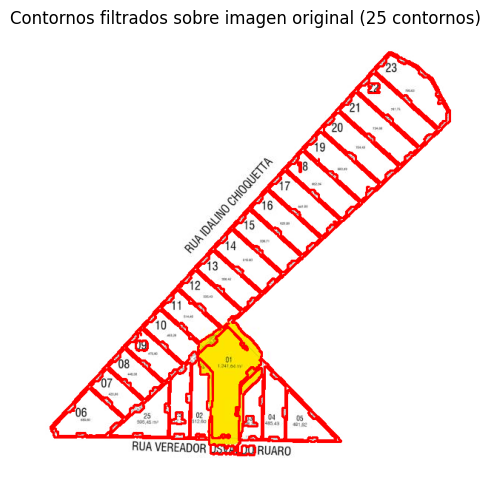


Procesando: ./data/plano8.png


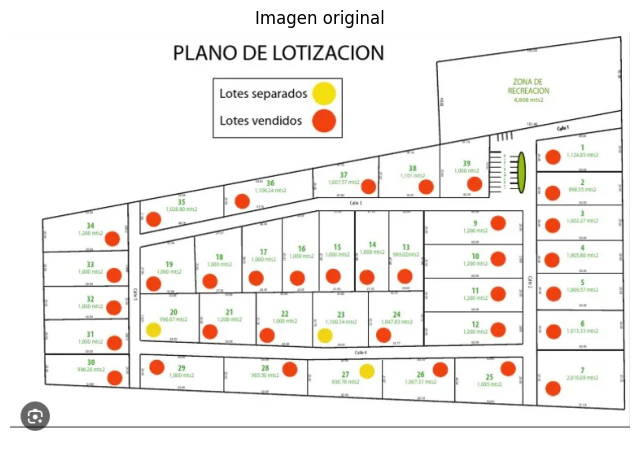

Contornos totales encontrados: 1143
Contornos filtrados (área > 1000): 46


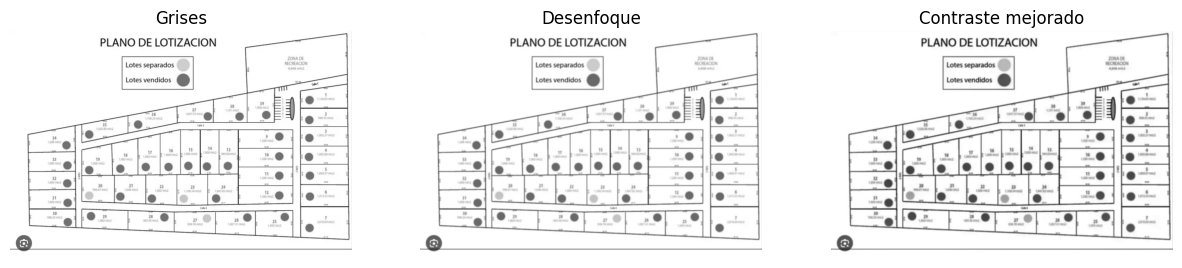

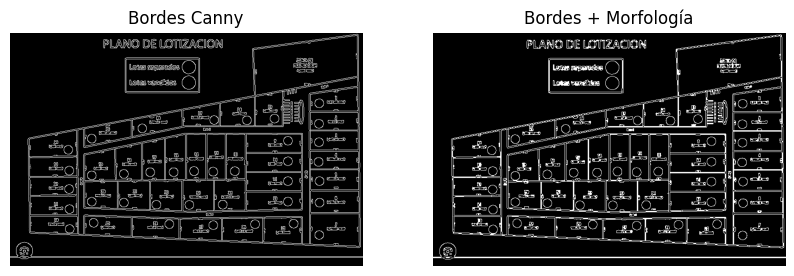

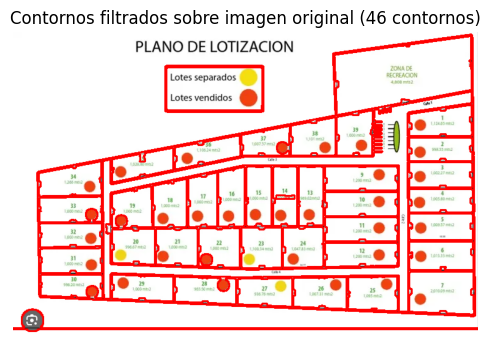


Procesando: ./data/plano9.png


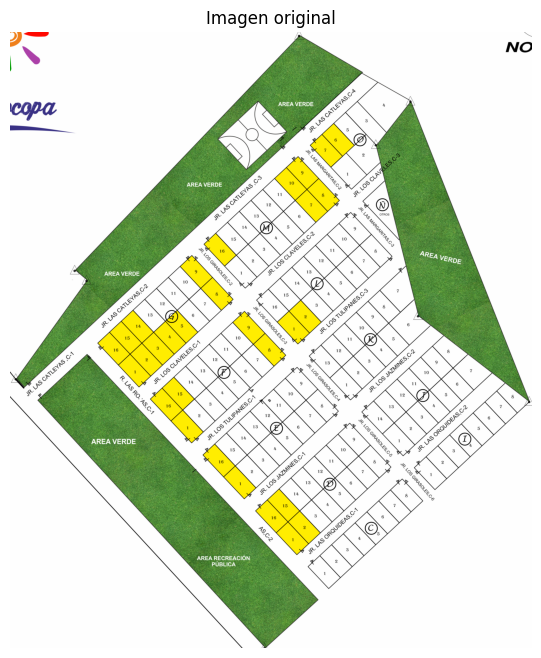

Contornos totales encontrados: 36490
Contornos filtrados (área > 1000): 194


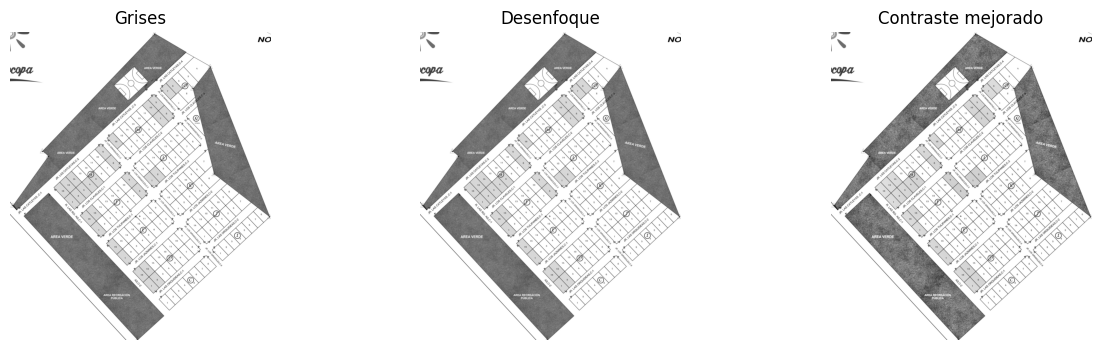

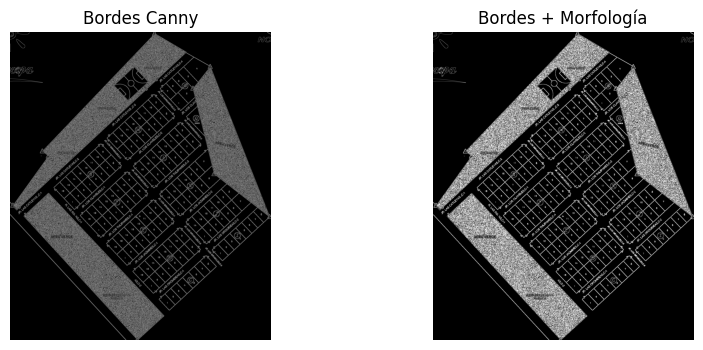

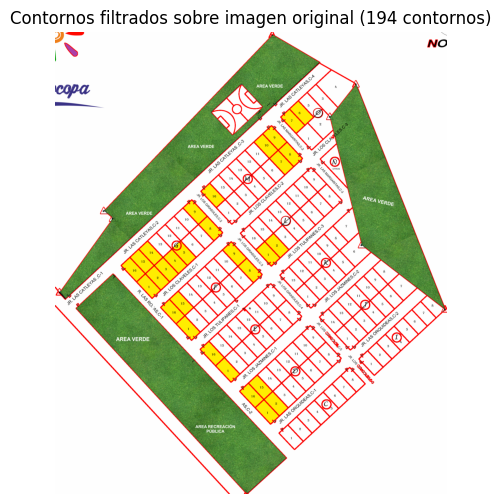


Procesando: ./data/plano10.png


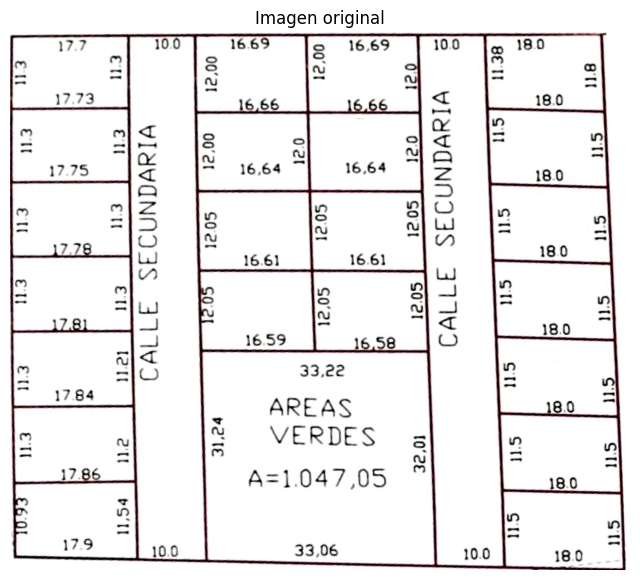

Contornos totales encontrados: 1207
Contornos filtrados (área > 1000): 8


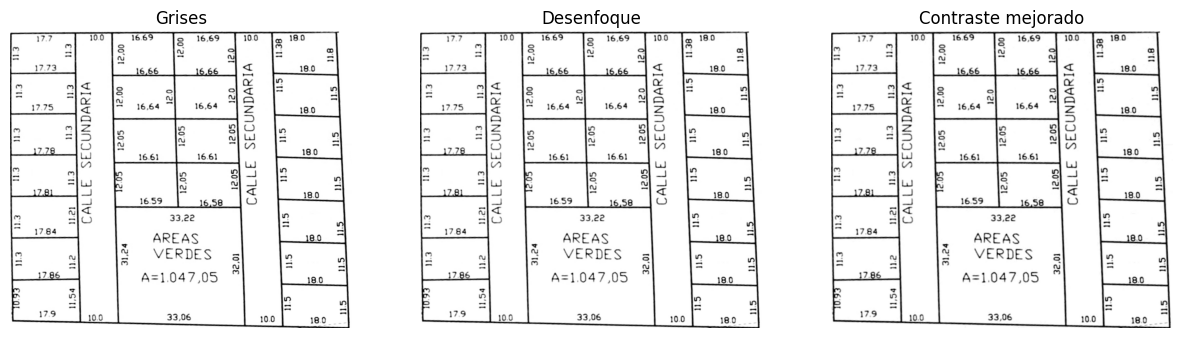

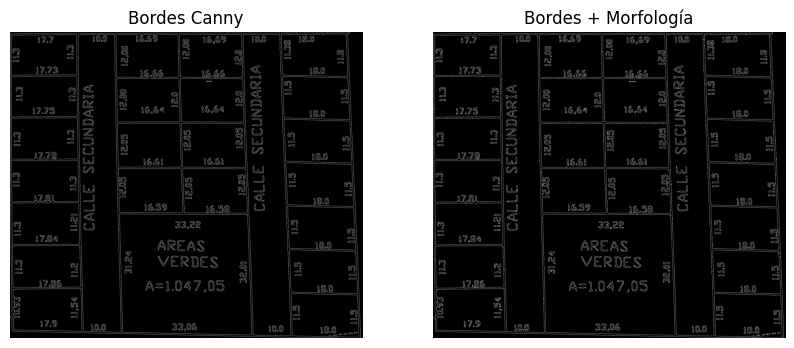

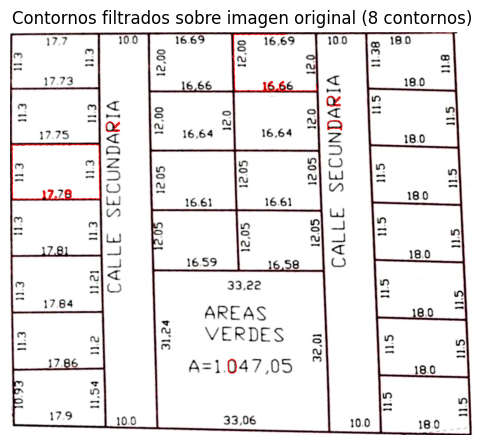


Procesando: ./data/plano11.png


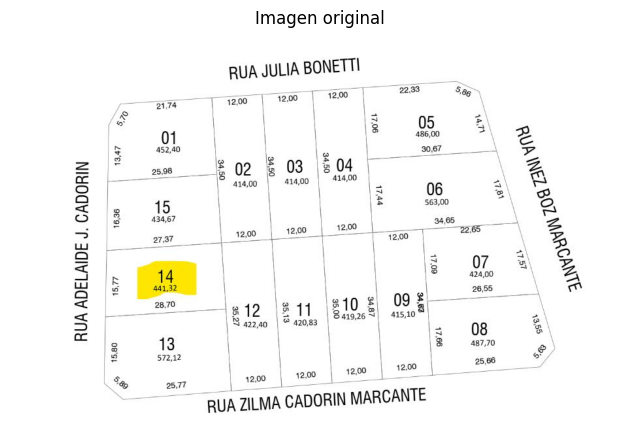

Contornos totales encontrados: 1413
Contornos filtrados (área > 1000): 16


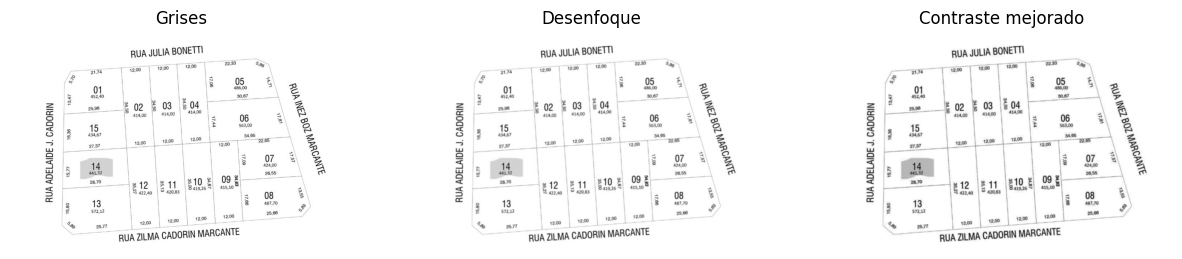

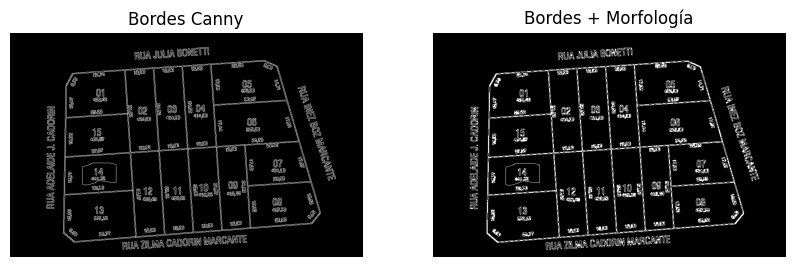

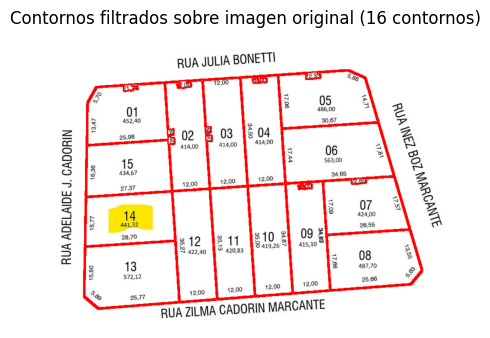


Procesando: ./data/plano12.png


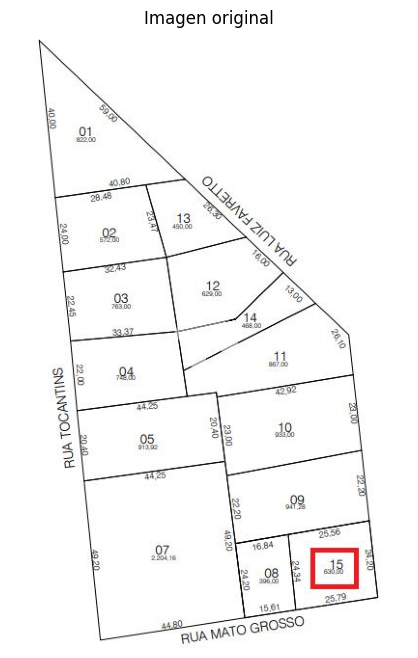

Contornos totales encontrados: 800
Contornos filtrados (área > 1000): 20


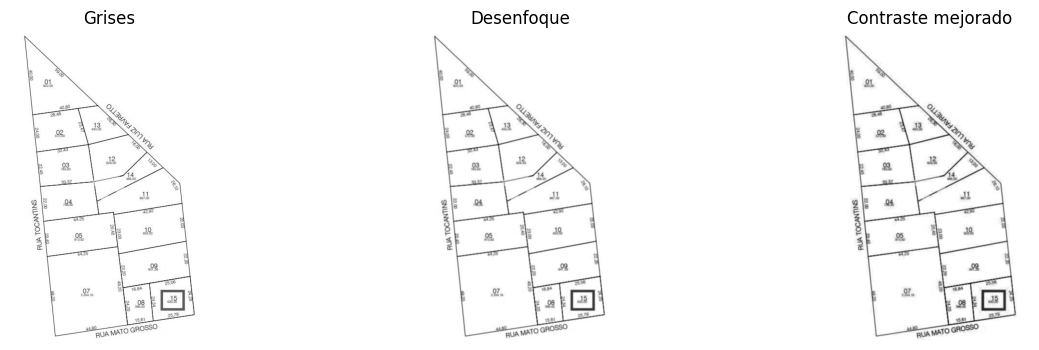

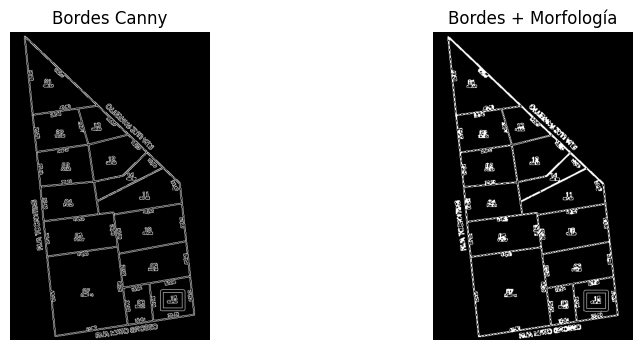

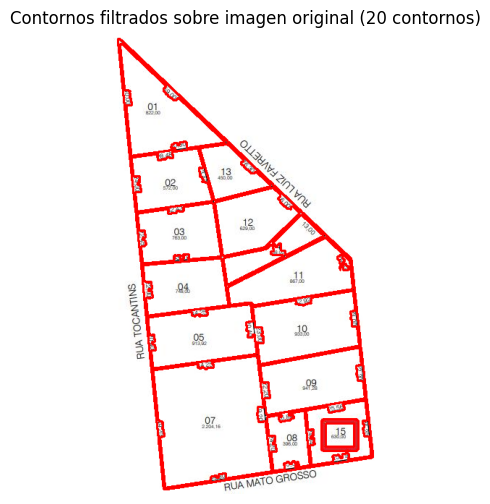


Procesando: ./data/plano13.png


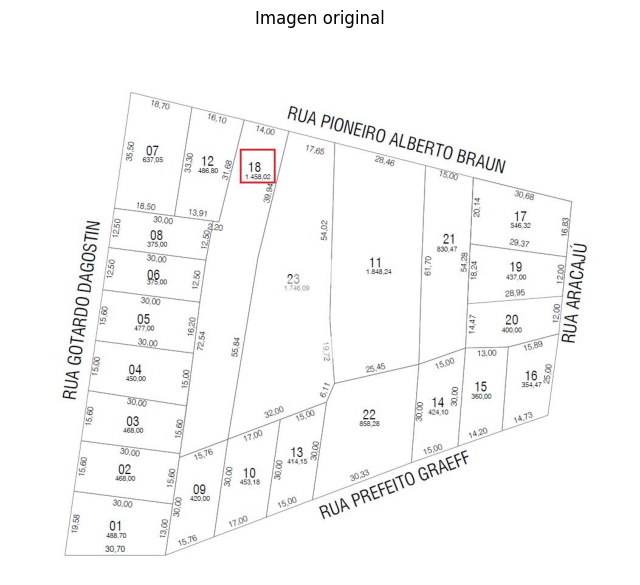

Contornos totales encontrados: 2698
Contornos filtrados (área > 1000): 27


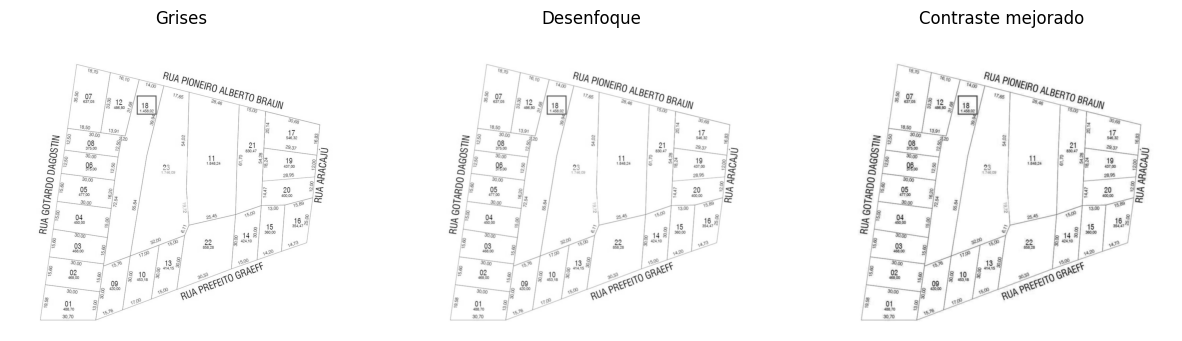

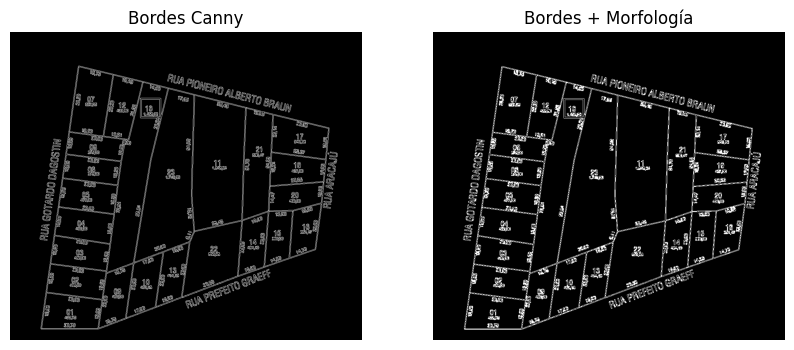

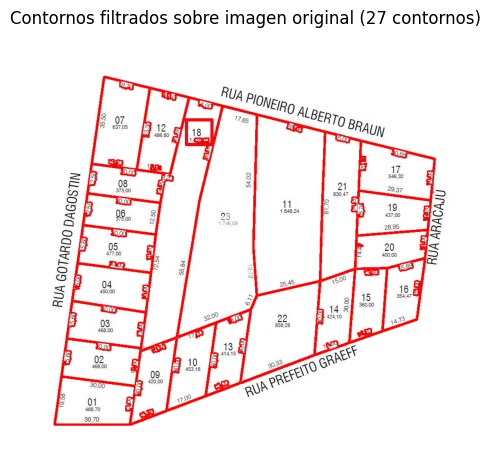


Procesando: ./data/plano14.png


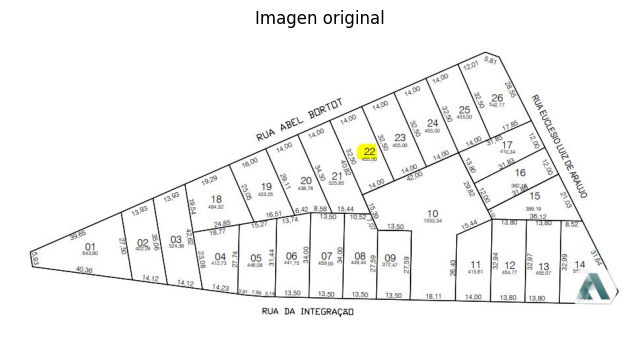

Contornos totales encontrados: 1447
Contornos filtrados (área > 1000): 27


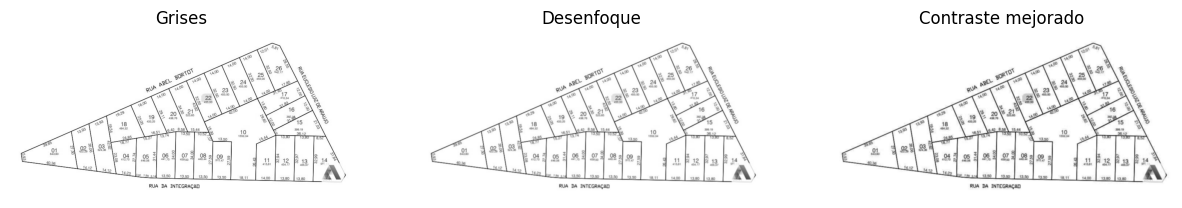

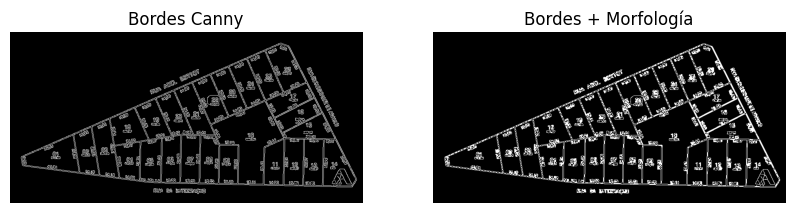

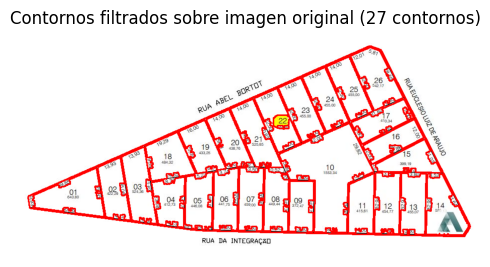


Procesando: ./data/plano15.png


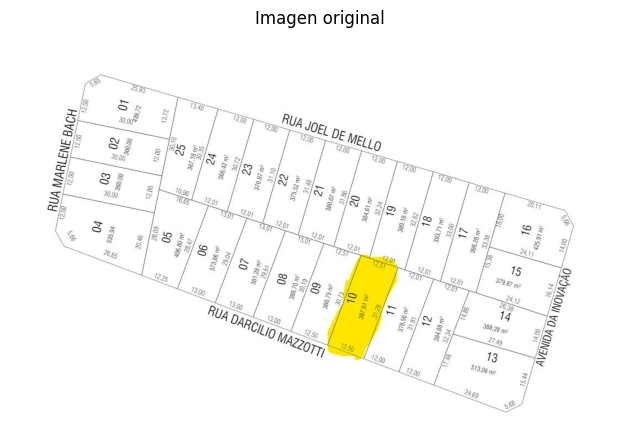

Contornos totales encontrados: 3100
Contornos filtrados (área > 1000): 28


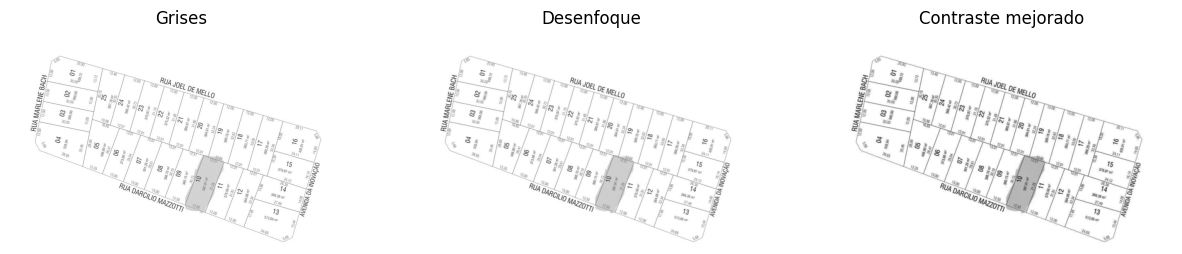

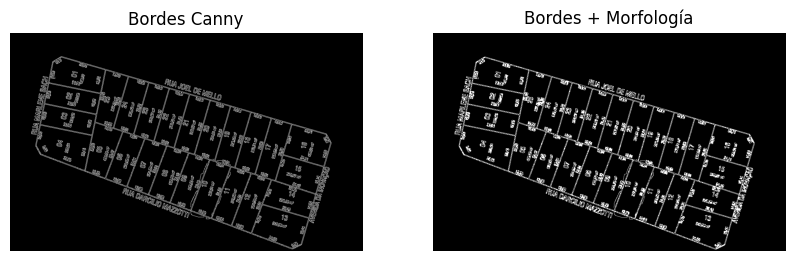

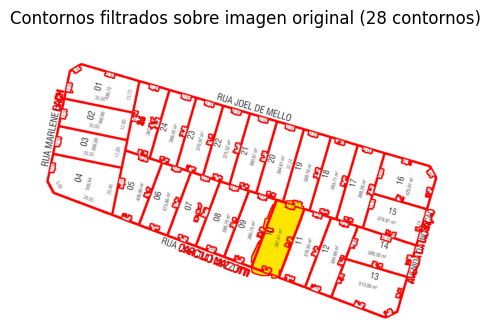


Procesando: ./data/plano16.png


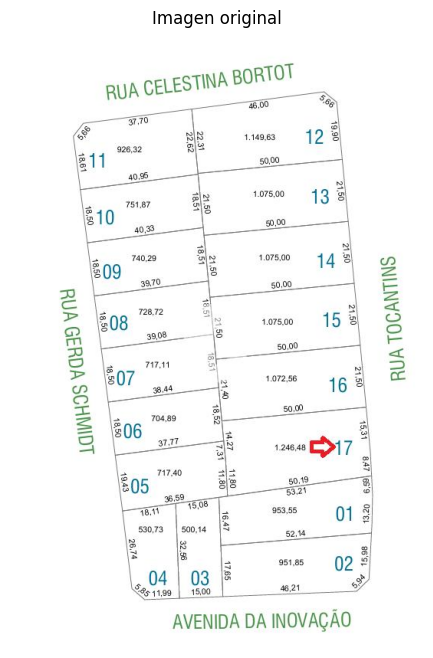

Contornos totales encontrados: 1585
Contornos filtrados (área > 1000): 18


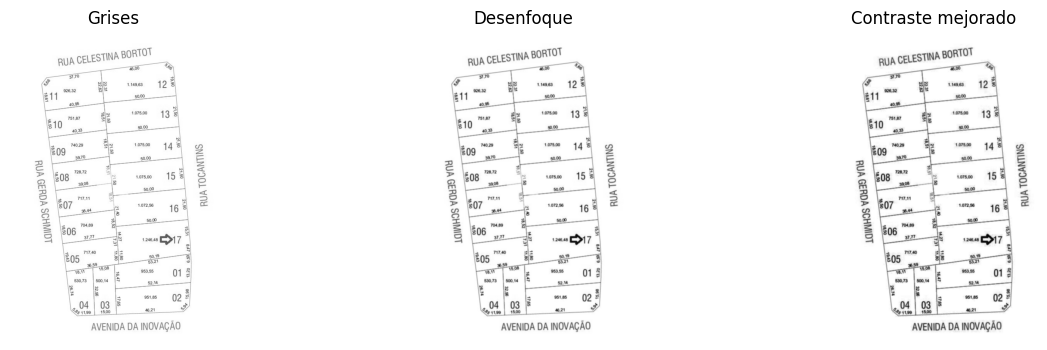

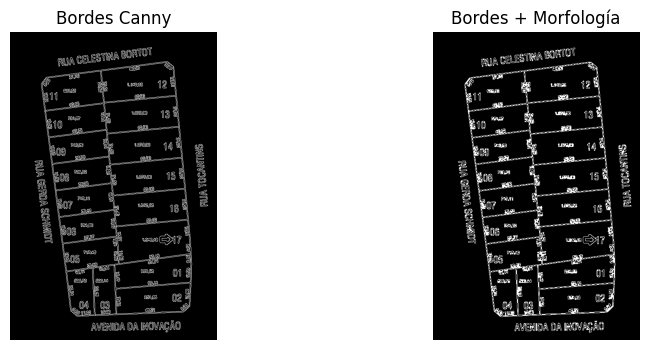

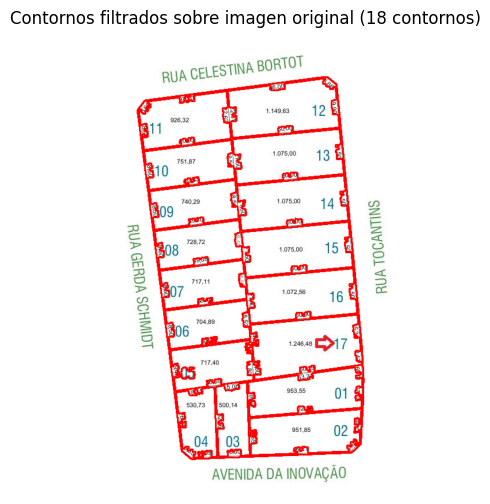

In [11]:
# Procesar varias imágenes automáticamente
input_paths = [
    './data/plano1.png',
    './data/plano2.jpg',
    './data/plano3.jpeg',
    './data/plano4.jpeg',
    './data/plano5.png',
    './data/plano6.png',
    './data/plano7.png',
    './data/plano8.png',
    './data/plano9.png',
    './data/plano10.png',
    './data/plano11.png',
    './data/plano12.png',
    './data/plano13.png',
    './data/plano14.png',
    './data/plano15.png',
    './data/plano16.png',
]

for path in input_paths:
    print(f"\nProcesando: {path}")
    image_bgr = load_image(path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.title('Imagen original')
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

    # Preprocesamiento con filtrado
    gray, blurred, contrast, edges, edges_morph, filtered_contours = preprocesar_imagen(image_bgr, CFG)

    # Mostrar y guardar resultados
    mostrar_y_guardar_resultados(image_rgb, gray, blurred, contrast, edges, edges_morph, filtered_contours)